# Modelagem de séries temporais usando redes neurais recorrentes


In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import savgol_filter # filtro para suavizar a série

In [5]:
pkgdir = 'Data'

df = pd.read_csv(f'{pkgdir}/owid-covid-data.csv', index_col='date', parse_dates=True)
df = df[df['location']=='Brazil']
population = df['population'][0]

In [6]:
df.columns

Index(['iso_code', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vac

In [23]:
# Leitura dos dados de COVID-19 do Brasil

pkgdir = 'Data'

df = pd.read_csv(f'{pkgdir}/owid-covid-data.csv', index_col='date', parse_dates=True)
df = df[df['location']=='Brazil']
population = df['population'][0]

# Seleciona apenas o número de casos e mortes diários
df = df[['new_cases','new_deaths']]

# Preenche os dados faltantes com interploção spline
df.interpolate('spline',order=2,inplace=True)

# filtragem da série usando o filtro Savitzky-Golay
df['new_cases'] = savgol_filter(df['new_cases'], 7, 2)
df['new_deaths'] = savgol_filter(df['new_deaths'], 7, 2)

#df2 = pd.DataFrame()
#window = 35
#df2['new_cases_f'] = pd.Series(df['new_cases']).rolling(window=window).mean().iloc[window-1:].values
#df2['new_deaths_f'] = pd.Series(df['new_deaths']).rolling(window=window).mean().iloc[window-1:].values
#df2.index = df.index[np.int((window-1)/2):-np.int((window-1)/2)]
#df = df2

df.columns = ['new_cases','new_deaths']
df = df[df.index>'2020-04-01']
df = df[df.index<'2021-04-29']

idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(idx)
df.fillna(0,inplace=True)

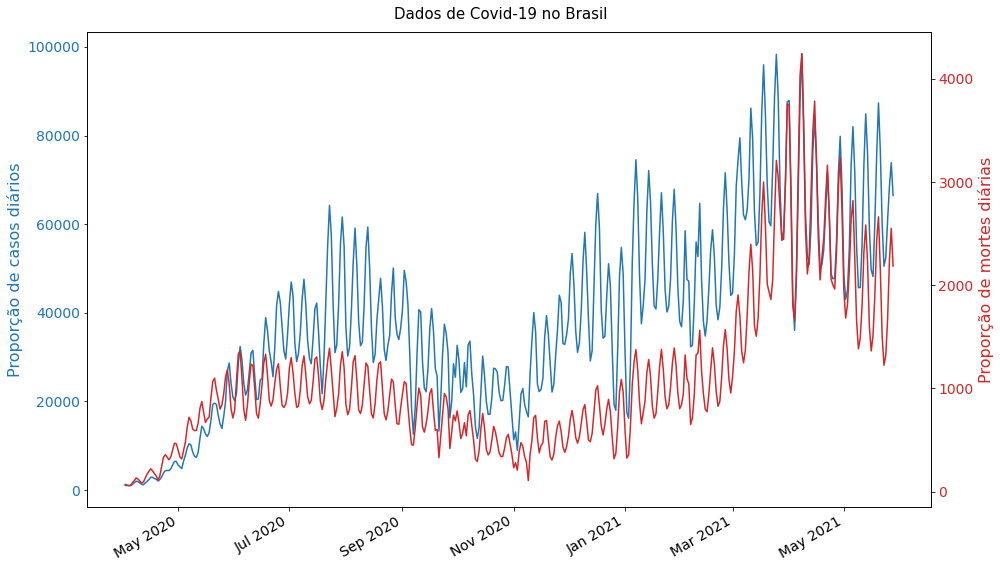

In [24]:
fig, ax1 = plt.subplots(figsize=(14,8))

color = 'tab:blue'
ax1.set_ylabel('Proporção de casos diários', color=color, fontsize=16)
ax1.plot(df['new_cases'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Proporção de mortes diárias', color=color, fontsize=16)  # we already handled the x-label with ax1
ax2.plot(df['new_deaths'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='both', which='major', labelsize=14)
date_fmt = mdates.DateFormatter('%b %Y')
ax1.xaxis.set_major_formatter(date_fmt)
ax2.xaxis.set_major_formatter(date_fmt)
fig.suptitle("Dados de Covid-19 no Brasil",
             fontsize=15)
fig.autofmt_xdate()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Importante: Os dados precisam estar normalizados

In [4]:
# Normalização pela população vezes 10^3 e 10^4 para o número de casos e de mortes, respectivamente,
# para os valores não ficarem tão próximos a zero
df = [1000,10000]*df/population

## Divida a base em treino e teste

In [5]:
train = df.iloc[:-28]
test = df.iloc[-28:]

Y_train = train.to_numpy()
Y_test = test.to_numpy()

### Gerador de séries temporais


In [6]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [7]:
# Vamos redefinir lotes de tamanho 28 para o procedimento iterativo
# Veja mais informações sobre o tamanho do lote http://deeplearningbook.com.br/o-efeito-do-batch-size-no-treinamento-de-redes-neurais-artificiais/

n_input_cases = 28
n_input_deaths = 14
n_features = 1
generator_cases = TimeseriesGenerator(Y_train[:,[0,1]], Y_train[:,[2]], length=n_input_cases, batch_size=1)
generator_only_deaths = TimeseriesGenerator(Y_train[:,[1]], Y_train[:,[1]], length=n_input_deaths, batch_size=1)

### Definição do modelo usando Keras

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [9]:
# Modelo usando o número de casos como preditora
model_cases = Sequential()
model_cases.add(LSTM(56, activation='relu', unroll = True, input_shape=(n_input_cases, n_features)))
model_cases.add(Dense(1))
model_cases.compile(optimizer='adam', loss='mse')

In [10]:
# Modelo usando o número de mortes
model_deaths = Sequential()
model_deaths.add(LSTM(56, activation='relu', unroll = True, input_shape=(n_input_deaths, n_features)))
model_deaths.add(Dense(1))
model_deaths.compile(optimizer='adam', loss='mse')

In [11]:
model_cases.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 56)                12992     
_________________________________________________________________
dense (Dense)                (None, 1)                 57        
Total params: 13,049
Trainable params: 13,049
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Ajuste do modelo com o número de casos diários

model_cases.fit(generator_cases,epochs=200)

Epoch 1/200
336/336 [==============================] - 4s 3ms/step - loss: 3.9216e-04
Epoch 2/200
336/336 [==============================] - 1s 3ms/step - loss: 3.2651e-04
Epoch 3/200
336/336 [==============================] - 1s 3ms/step - loss: 3.0463e-04
Epoch 4/200
336/336 [==============================] - 1s 3ms/step - loss: 3.3488e-04
Epoch 5/200
336/336 [==============================] - 1s 3ms/step - loss: 3.3797e-04
Epoch 6/200
336/336 [==============================] - 1s 3ms/step - loss: 2.9947e-04A: 0s 
Epoch 7/200
336/336 [==============================] - 1s 3ms/step - loss: 2.7732e-04
Epoch 8/200
336/336 [==============================] - 1s 3ms/step - loss: 2.5675e-04
Epoch 9/200
336/336 [==============================] - 1s 3ms/step - loss: 2.7123e-04
Epoch 10/200
336/336 [==============================] - 1s 3ms/step - loss: 2.5332e-04
Epoch 11/200
336/336 [==============================] - 1s 3ms/step - loss: 2.4230e-04
Epoch 12/200
336/336 [========================

336/336 [==============================] - 1s 3ms/step - loss: 1.1583e-04
Epoch 96/200
336/336 [==============================] - 1s 3ms/step - loss: 1.1348e-04
Epoch 97/200
336/336 [==============================] - 1s 3ms/step - loss: 1.1876e-04
Epoch 98/200
336/336 [==============================] - 1s 3ms/step - loss: 1.1513e-04
Epoch 99/200
336/336 [==============================] - 1s 3ms/step - loss: 1.2211e-04
Epoch 100/200
336/336 [==============================] - 1s 3ms/step - loss: 1.1496e-04
Epoch 101/200
336/336 [==============================] - 1s 3ms/step - loss: 1.1752e-04
Epoch 102/200
336/336 [==============================] - 1s 3ms/step - loss: 1.2934e-04
Epoch 103/200
336/336 [==============================] - 1s 3ms/step - loss: 1.1417e-04
Epoch 104/200
336/336 [==============================] - 1s 3ms/step - loss: 1.1773e-04
Epoch 105/200
336/336 [==============================] - 1s 3ms/step - loss: 1.1305e-04
Epoch 106/200
336/336 [===========================

In [13]:
# Ajuste do modelo apenas com o número de mortes diárias

model_deaths.fit(generator_only_deaths,epochs=200)

Epoch 1/200
350/350 [==============================] - 2s 2ms/step - loss: 3.4460e-04
Epoch 2/200
350/350 [==============================] - 1s 2ms/step - loss: 1.9434e-04
Epoch 3/200
350/350 [==============================] - 1s 2ms/step - loss: 1.5901e-04
Epoch 4/200
350/350 [==============================] - 1s 2ms/step - loss: 1.6949e-04
Epoch 5/200
350/350 [==============================] - 1s 2ms/step - loss: 1.7065e-04
Epoch 6/200
350/350 [==============================] - 1s 2ms/step - loss: 1.5636e-04
Epoch 7/200
350/350 [==============================] - 1s 2ms/step - loss: 1.6918e-04
Epoch 8/200
350/350 [==============================] - 1s 2ms/step - loss: 1.5742e-04
Epoch 9/200
350/350 [==============================] - 1s 2ms/step - loss: 1.4904e-04
Epoch 10/200
350/350 [==============================] - 1s 2ms/step - loss: 1.5989e-04
Epoch 11/200
350/350 [==============================] - 1s 2ms/step - loss: 1.4763e-04
Epoch 12/200
350/350 [==============================

350/350 [==============================] - 1s 2ms/step - loss: 1.7589e-05
Epoch 189/200
350/350 [==============================] - 1s 2ms/step - loss: 1.8702e-05
Epoch 190/200
350/350 [==============================] - 1s 2ms/step - loss: 1.6705e-05
Epoch 191/200
350/350 [==============================] - 1s 2ms/step - loss: 1.8263e-05
Epoch 192/200
350/350 [==============================] - 1s 2ms/step - loss: 1.7106e-05
Epoch 193/200
350/350 [==============================] - 1s 2ms/step - loss: 1.7328e-05
Epoch 194/200
350/350 [==============================] - 1s 2ms/step - loss: 1.9658e-05
Epoch 195/200
350/350 [==============================] - 1s 2ms/step - loss: 1.6969e-05
Epoch 196/200
350/350 [==============================] - 1s 2ms/step - loss: 1.8819e-05
Epoch 197/200
350/350 [==============================] - 1s 2ms/step - loss: 1.8417e-05
Epoch 198/200
350/350 [==============================] - 1s 2ms/step - loss: 1.7947e-05
Epoch 199/200
350/350 [=======================

**Erro dos modelos no aprendizado**

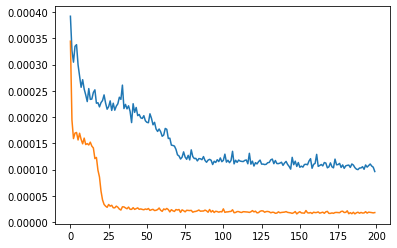

In [14]:
model_cases_loss = model_cases.history.history['loss']
model_deaths_loss = model_deaths.history.history['loss']
plt.plot(range(len(model_cases_loss)),model_cases_loss)
plt.plot(range(len(model_deaths_loss)),model_deaths_loss)

## Avaliação em dados de teste

In [15]:
# Agora vamos calcular as previsões do model_cases para as próximas observações

test_predictions_cases = []

first_eval_batch = Y_train[-n_input_cases:,[0]]
current_batch = first_eval_batch.reshape((1, n_input_cases, n_features))

for i in range(len(test)):
    current_batch = np.append(current_batch[:,1:,:],[[Y_test[i,[0]]]],axis=1)
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model_cases.predict(current_batch)[0]
    
    # predição
    test_predictions_cases.append(current_pred) 
    

In [16]:
# Agora vamos calcular as previsões do model_deaths para as próximas observações

test_predictions_deaths = []

first_eval_batch = Y_train[-n_input_deaths:,[1]]
current_batch = first_eval_batch.reshape((1, n_input_deaths, n_features))

for i in range(len(test)):
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model_deaths.predict(current_batch)[0]
    
    # predição
    test_predictions_deaths.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Retorno da normalização e comparação das previsões

In [17]:
# Possivelmente encontraremos warnings aqui
df['new_deaths2'] = population*df['new_deaths']/10000
test['Predictions_with_cases'] = np.concatenate((Y_test[:,[0]], test_predictions_cases),axis=1)[:,[1]]
test['Predictions_with_deaths'] = np.concatenate((Y_test[:,[0]], test_predictions_deaths),axis=1)[:,[1]]

test['new_deaths2'] = population*test['new_deaths']/10000
test['Predictions_with_cases2'] = population*test['Predictions_with_cases']/10000
test['Predictions_with_deaths2'] = population*test['Predictions_with_deaths']/10000

<ipython-input-17-94193b7a3f64>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-17-94193b7a3f64>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-17-94193b7a3f64>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-17-94193b7

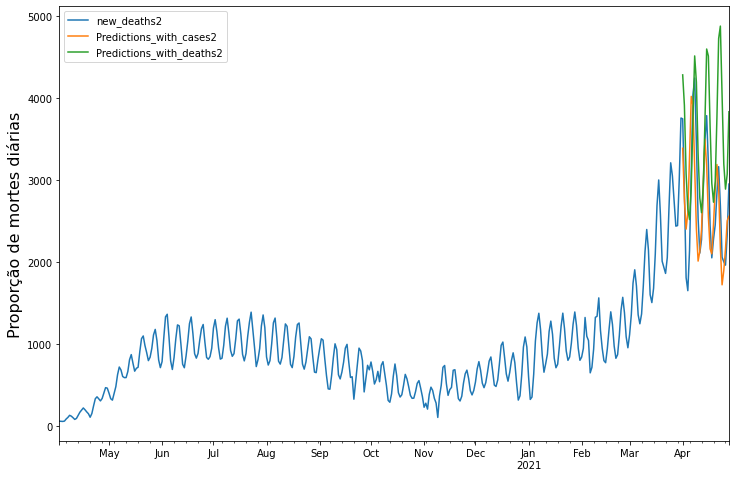

In [18]:
ax = df['new_deaths2'].plot(figsize=(12,8))
ax.set_ylabel('Proporção de mortes diárias', fontsize=16) 
test['Predictions_with_cases2'].plot(ax=ax)
test['Predictions_with_deaths2'].plot(ax=ax)
ax.legend()

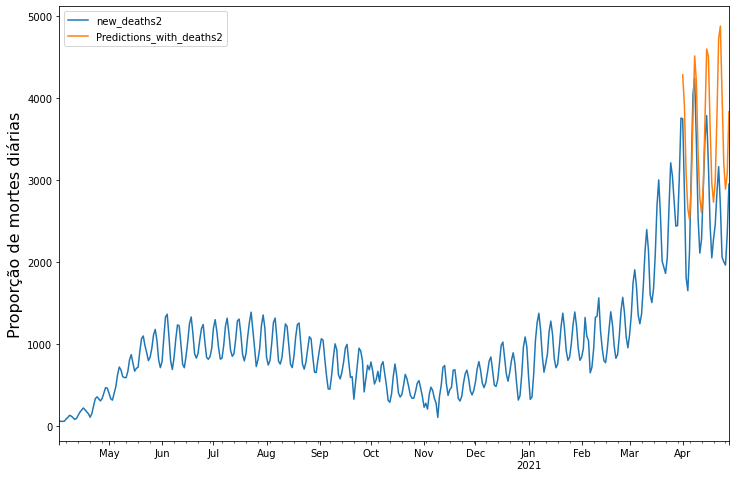

In [19]:
ax = df['new_deaths2'].plot(figsize=(12,8))
ax.set_ylabel('Proporção de mortes diárias', fontsize=16) 
test['Predictions_with_deaths2'].plot(ax=ax)
ax.legend()

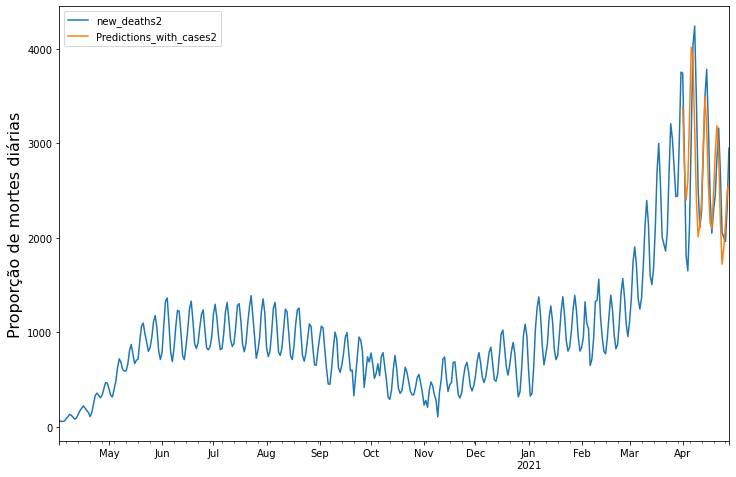

In [20]:
ax = df['new_deaths2'].plot(figsize=(12,8))
ax.set_ylabel('Proporção de mortes diárias', fontsize=16) 
test['Predictions_with_cases2'].plot(ax=ax)
ax.legend()

## Erro relativo

In [21]:
relative_errors = pd.DataFrame()
relative_errors['Predictions_with_deaths'] = round(100*np.abs(test['Predictions_with_deaths2']-test['new_deaths2'])/
                                                   test['new_deaths2'],2)
relative_errors['Predictions_with_cases'] = round(100*np.abs(test['Predictions_with_cases2']-test['new_deaths2'])/
                                                   test['new_deaths2'],2)
relative_errors

Predictions_with_deaths  Predictions_with_cases
2021-04-01                    14.30                    9.58
2021-04-02                    36.52                    3.50
2021-04-03                    69.77                   32.63
2021-04-04                    60.56                   57.55
2021-04-05                    17.60                   53.41
2021-04-06                     6.53                   29.08
2021-04-07                     6.85                    3.23
2021-04-08                     6.35                   25.80
2021-04-09                    21.25                   30.37
2021-04-10                    30.88                   20.61
2021-04-11                    31.81                    1.06
2021-04-12                    14.41                    5.24
2021-04-13                     1.09                    2.47
2021-04-14                     6.45                    0.11
2021-04-15                    21.46                   16.16
2021-04-16                    41.11                   20.20
2021-04-17                    49.38                   11.80
2021-04-18                    44.34                    2.40
2021-04-19                    19.78                    8.11
2021-04-20                    21.56                   17.90
2021-04-21                    32.48                   12.10
2021-04-22                    49.37                    7.99
2021-04-23                    81.39                   19.08
2021-04-24                    95.85                   16.33
2021-04-25                    59.59                    5.30
2021-04-26                    47.19                   10.04
2021-04-27                    31.62                    7.27
2021-04-28                    29.87                   13.28

In [22]:
# Erro relativo médio
relative_errors.mean()

Predictions_with_deaths    33.905714
Predictions_with_cases     15.807143
dtype: float64